In [60]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import image_dataset_from_directory
import os
from keras.utils import load_img, img_to_array
from matplotlib.lines import Line2D


In [61]:
# Step 1: Load and preprocess the image dataset
# Load the image dataset
data = image_dataset_from_directory(
    'flowers', 
    image_size=(128, 128),
    batch_size=32
)

# Normalize images and prepare labels
images, labels = [], []
for image_batch, label_batch in data:
    images.append(image_batch.numpy())
    labels.append(label_batch.numpy())

images = np.concatenate(images) / 255.0 
labels = np.concatenate(labels)

Found 1517 files belonging to 2 classes.


In [62]:
# Step 2: train a simple CNN model for embedding extraction
inputs = Input(shape=(128, 128, 3), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)
x = MaxPooling2D(2, name='Pool1')(x)
x = Conv2D(16, 3, activation="relu", padding='same', name='Conv2')(x)
x = MaxPooling2D(2, name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x = Dense(128, activation="relu", name="Dense1")(x)  # Embedding layer
x = Dense(3, name='FC')(x)
outputs = Activation("softmax", name='Softmax')(x)

# Compile the CNN model
cnn_model = Model(inputs, outputs)
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])

# Train the CNN
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, test_size=0.2, random_state=11)
cnn_model.fit(
    X_train,
    to_categorical(y_train, num_classes=3),
    validation_split=0.15,
    batch_size=32,
    epochs=5  # Keep epochs low for quicker training
)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - acc: 0.5558 - loss: 0.7579 - val_acc: 0.8681 - val_loss: 0.2974
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - acc: 0.8740 - loss: 0.3577 - val_acc: 0.9176 - val_loss: 0.2123
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - acc: 0.9182 - loss: 0.2520 - val_acc: 0.9176 - val_loss: 0.2402
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - acc: 0.9298 - loss: 0.2002 - val_acc: 0.9341 - val_loss: 0.2066
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - acc: 0.9394 - loss: 0.1872 - val_acc: 0.8901 - val_loss: 0.2541


In [63]:
# Step 3: extract embeddings from the CNN
def extract_embeddings(cnn_model, images):
    
    feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer("Dense1").output)
    return feature_extractor.predict(images)

X_train_embed = extract_embeddings(cnn_model, X_train)
X_test_embed = extract_embeddings(cnn_model, X_test)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


In [64]:
# Step 4: train an XGBoost classifier on the embeddings
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_embed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## SHAP

In [65]:
# Step 5: SHAP & XGBOOST
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_embed)


In [66]:
def f(x):
    tmp = x.copy()
    return cnn_model(tmp)

In [67]:
# Step 7: SHAP  image masker
masker_blur = shap.maskers.Image("blur(128,128)", X_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))

##(0, 1, 2, ..., 303)
ind = [132]

shap_values_ = explainer(X_test[ind], max_evals=5000, batch_size=50)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.01s/it]               


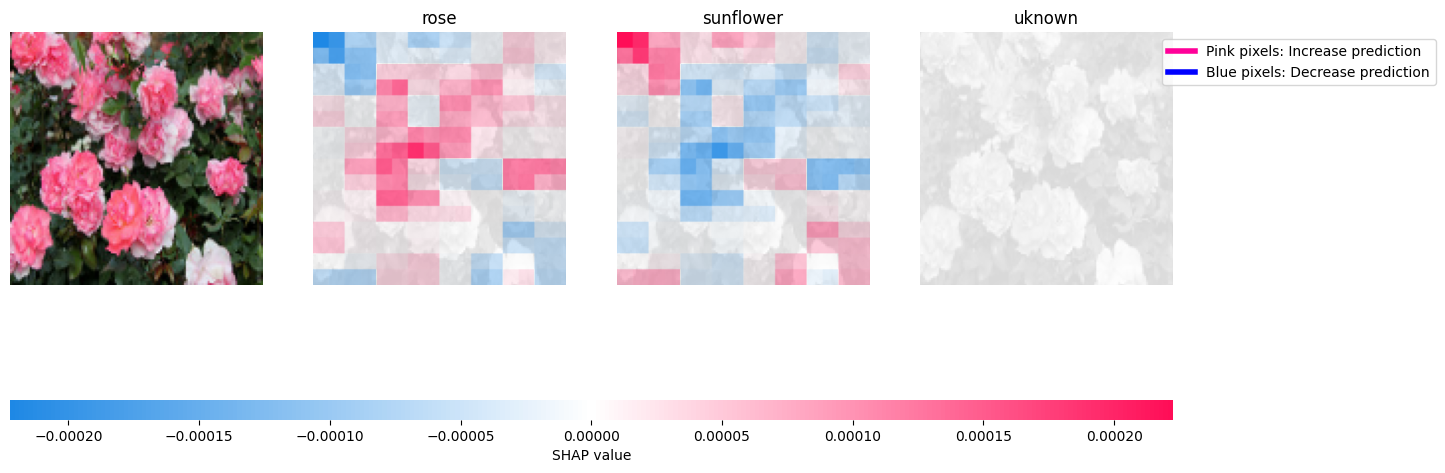

In [68]:
# Step 8: plot
shap.image_plot(shap_values_, X_test[ind], labels=['rose', 'sunflower', 'uknown'], show=False)

legend_elements = [
    Line2D([0], [0], color='#FF0099', lw=4, label='Pink pixels: Increase prediction'),
    Line2D([0], [0], color='blue', lw=4, label='Blue pixels: Decrease prediction')
]
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(1.5, 1))


plt.gcf().set_size_inches(15, 10)


plt.show()

## PROTOTYPES

In [ ]:
# Step 1: prototypes based on distance to centroid (best, worst,okay)
def find_prototypes(X_train_embed, y_train, n_prototypes=4):
    prototypes = []
    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        class_embeddings = X_train_embed[class_indices]
        
        
        centroid = np.mean(class_embeddings, axis=0)
        
        
        distances = np.linalg.norm(class_embeddings - centroid, axis=1)
        
       
        best_idx = np.argmin(distances)
        best_prototype = class_embeddings[best_idx]
        
       
        worst_idx = np.argmax(distances)
        worst_prototype = class_embeddings[worst_idx]
        
        
        sorted_idx = np.argsort(distances)
        
        okay_prototypes = class_embeddings[sorted_idx[1:-1]][:2]
        
       
        prototypes.append({
            'best': best_prototype,
            'worst': worst_prototype,
            'okay': okay_prototypes 
        })
    
    return prototypes

prototypes = find_prototypes(X_train_embed, y_train, n_prototypes=4)

In [70]:
# Step 2: visualize prototypes
def visualize_prototypes(prototypes, X_test_embed, y_test, prototype_type='best'):
    for class_label, proto_dict in enumerate(prototypes):
        prototype = proto_dict[prototype_type]
        
        if prototype_type == 'okay':
            
            for i, proto in enumerate(prototype):
                distances = np.linalg.norm(X_test_embed - proto, axis=1)
                prototype_image_index = np.argmin(distances) 
                
                plt.figure(figsize=(8, 8))
                plt.imshow(X_test[prototype_image_index])  
                plt.title(f"{['rose', 'sunflower', 'daisy'][class_label]} - Okay Prototype {i + 1}")
                plt.show()
        else:
            
            distances = np.linalg.norm(X_test_embed - prototype, axis=1)
            prototype_image_index = np.argmin(distances)  
            
            plt.figure(figsize=(8, 8))
            plt.imshow(X_test[prototype_image_index]) 
            plt.title(f"{['rose', 'sunflower', 'daisy'][class_label]} - {prototype_type.capitalize()} Prototype")
            plt.show()


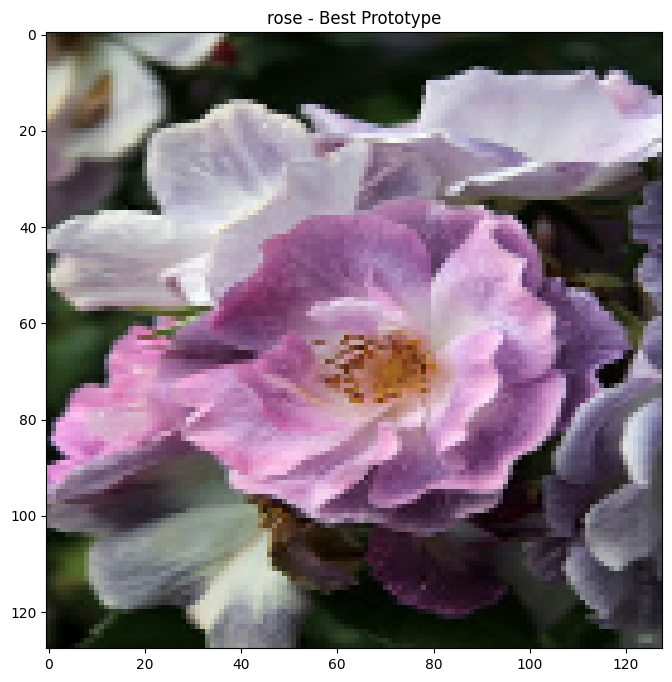

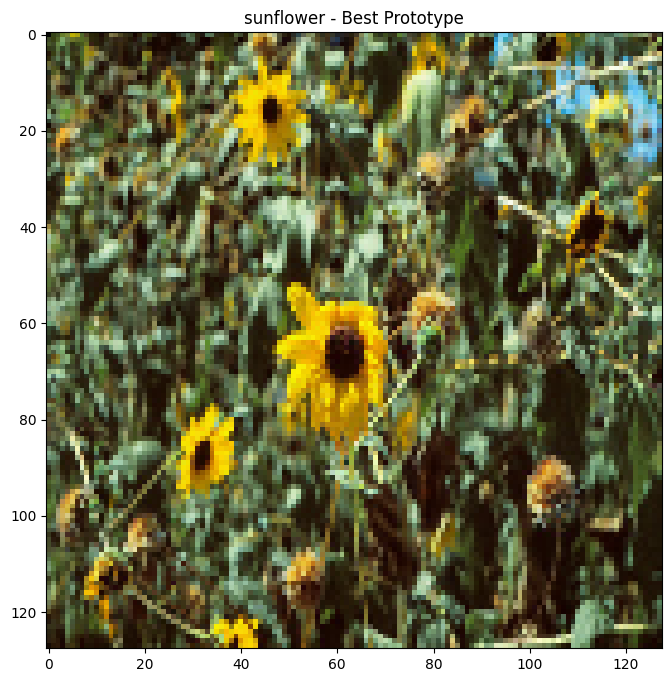

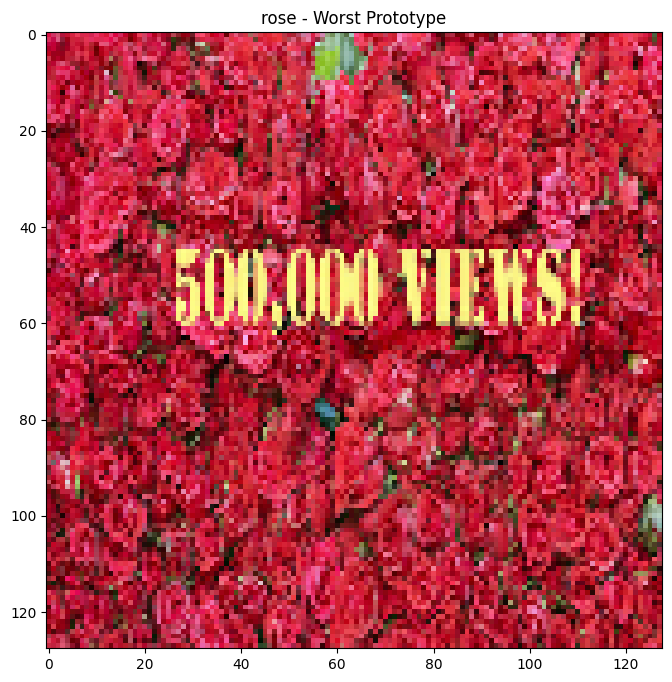

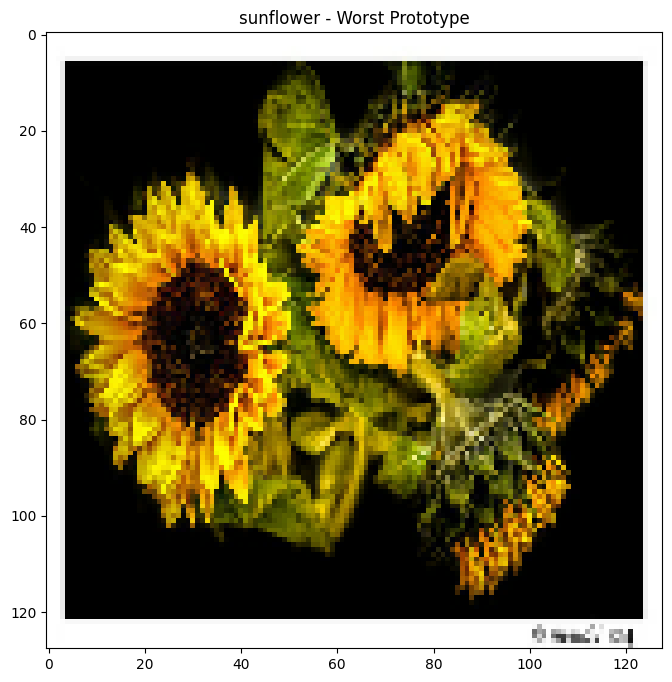

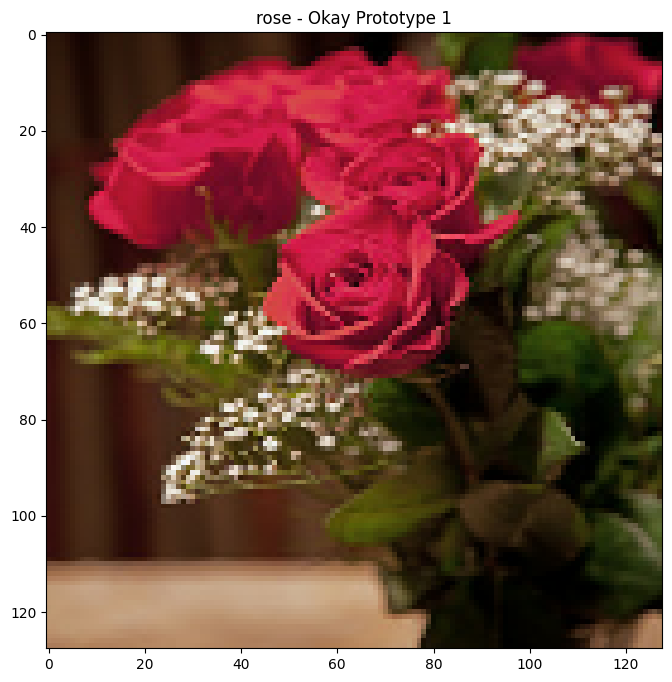

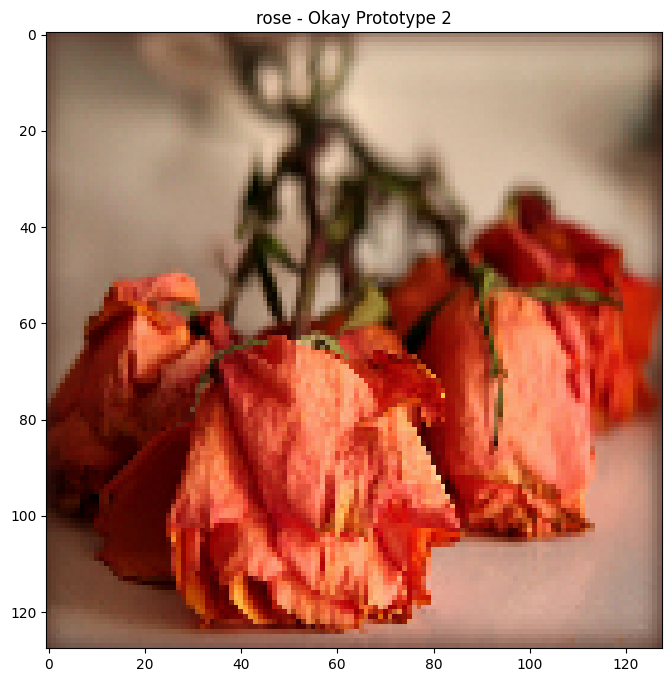

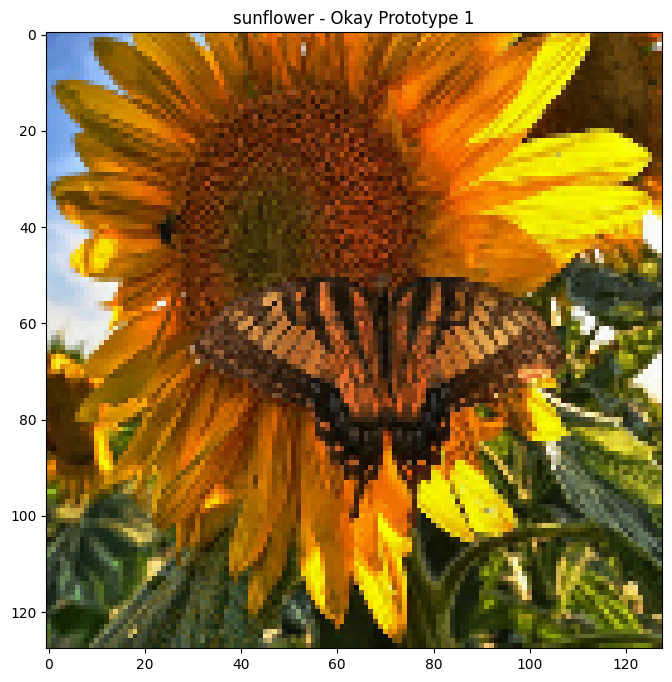

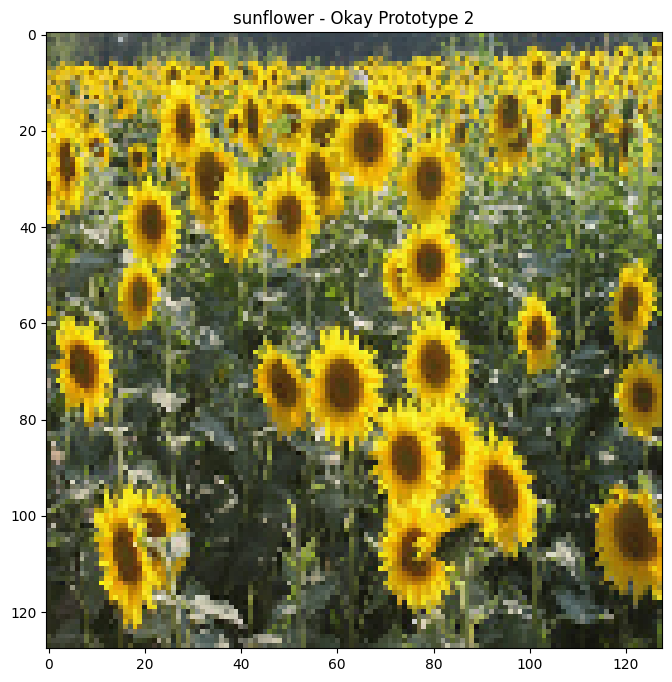

In [71]:


visualize_prototypes(prototypes, X_test_embed, y_test, prototype_type='best')

visualize_prototypes(prototypes, X_test_embed, y_test, prototype_type='worst')

visualize_prototypes(prototypes, X_test_embed, y_test, prototype_type='okay')


#### Try SHAP and PROTOTYPES with extra images

In [72]:
additional_images = []
for filename in os.listdir('test_images'):
    img = load_img(os.path.join('test_images', filename), target_size=(128, 128))
    img = img_to_array(img) / 255.0
    additional_images.append(img)

additional_images = np.array(additional_images)

In [73]:
additional_embeddings = extract_embeddings(cnn_model, additional_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [74]:
additional_predictions = xgb_model.predict(additional_embeddings)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.32s/it]               


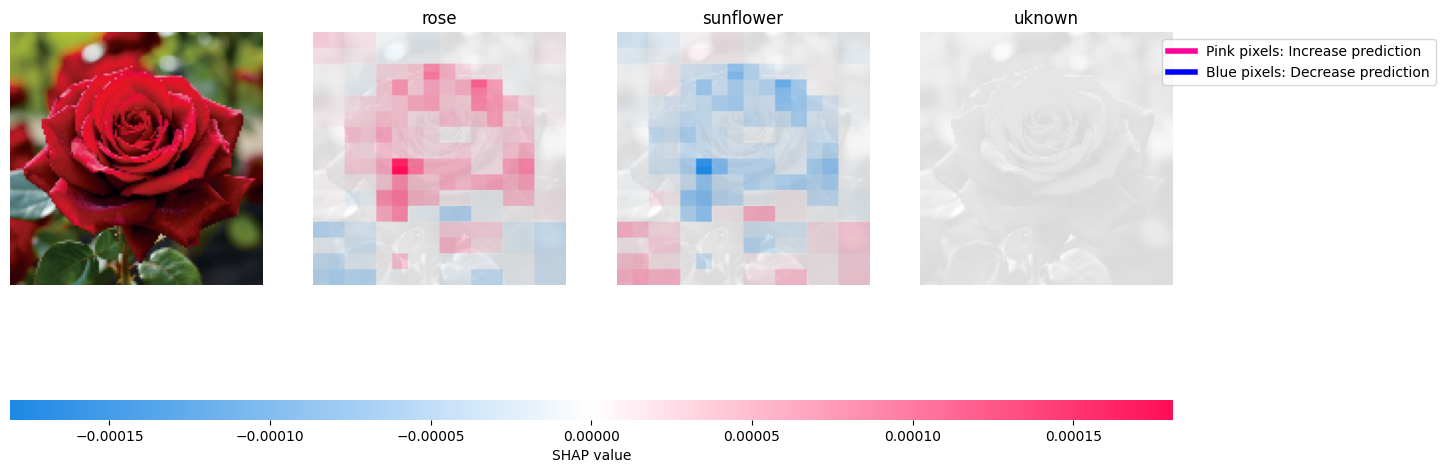

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.80s/it]               


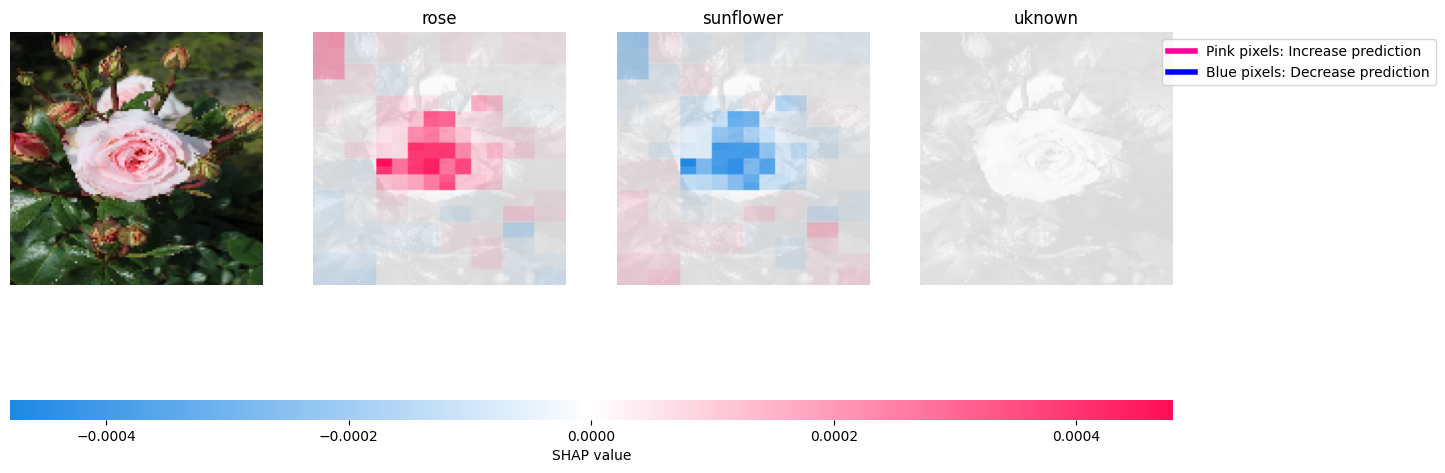

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.87s/it]               


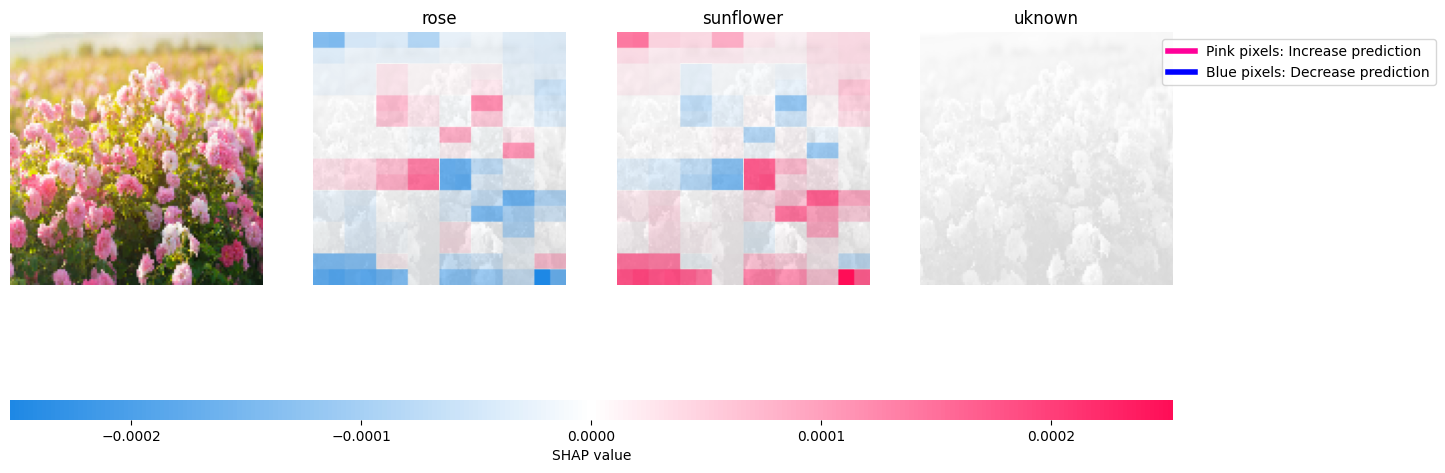

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.83s/it]               


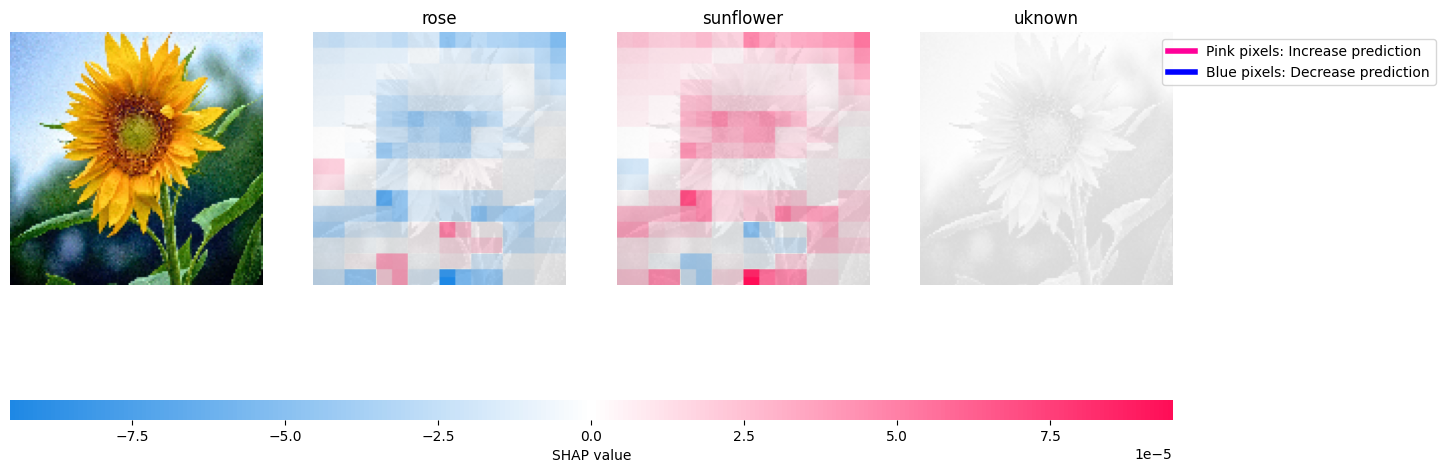

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.29s/it]               


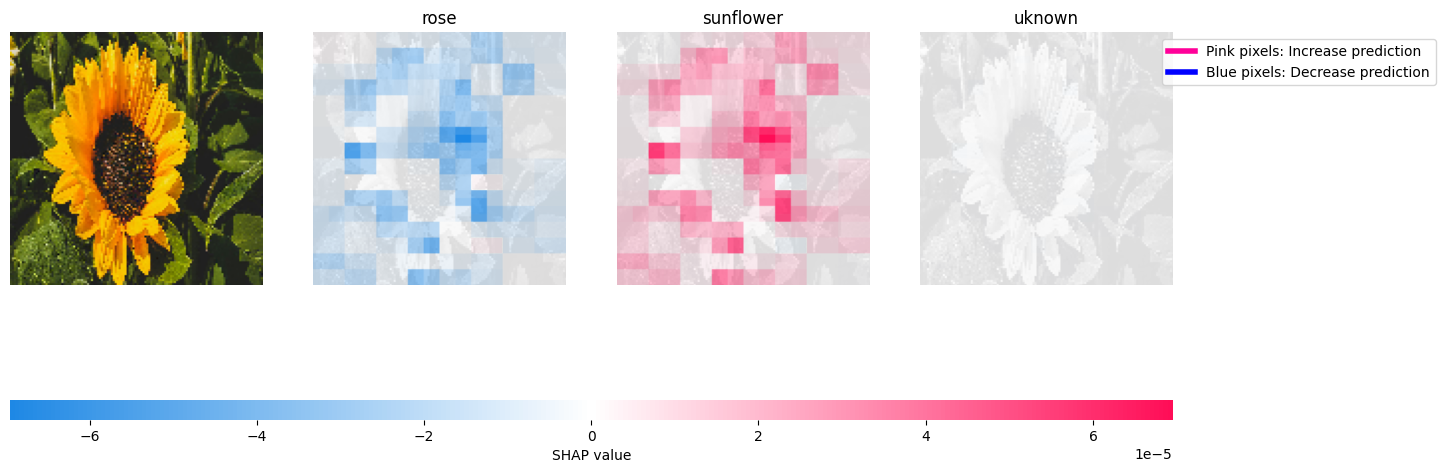

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.92s/it]               


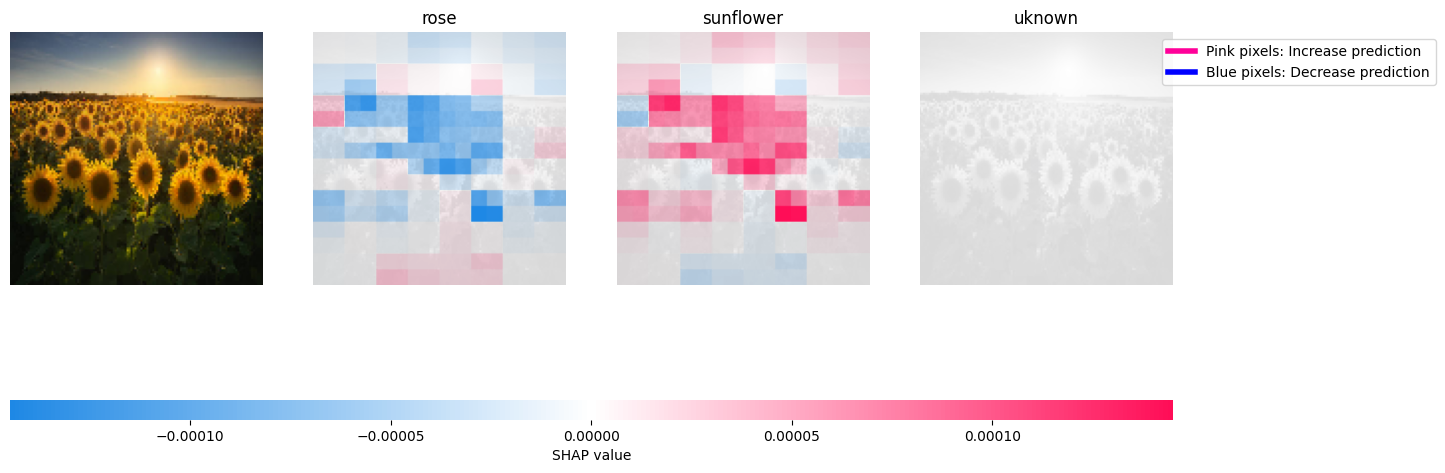

In [75]:
for i, image in enumerate(additional_images):
    shap_values_ = explainer(image[np.newaxis, ...], max_evals=5000, batch_size=50)
    shap.image_plot(shap_values_, image[np.newaxis, ...], labels=['rose', 'sunflower','uknown'], show=False)
    #plt.title(f"SHAP Explanation for Image {i+1}")

    legend_elements = [
        Line2D([0], [0], color='#FF0099', lw=4, label='Pink pixels: Increase prediction'),
        Line2D([0], [0], color='blue', lw=4, label='Blue pixels: Decrease prediction')
    ]

    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(1.5, 1))
    plt.gcf().set_size_inches(15, 10)
    plt.show()
   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


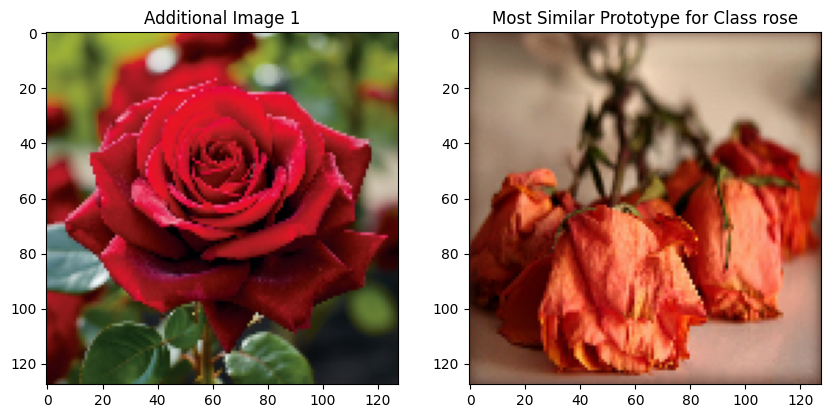

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


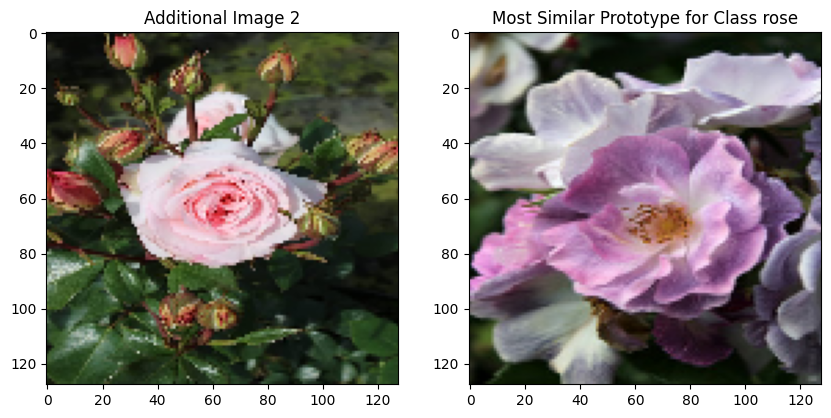

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


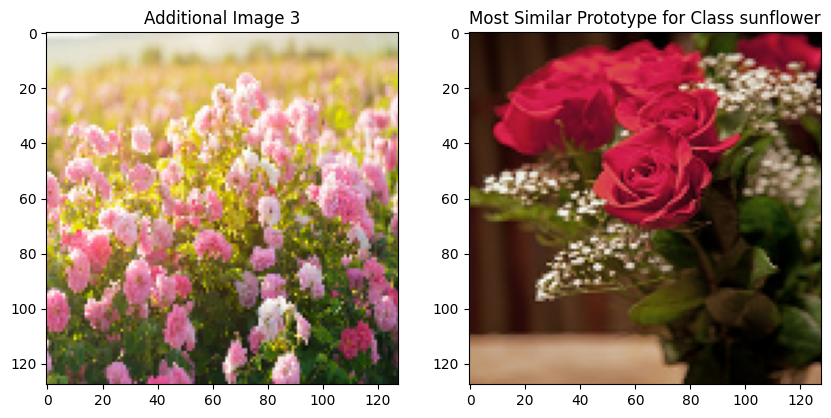

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


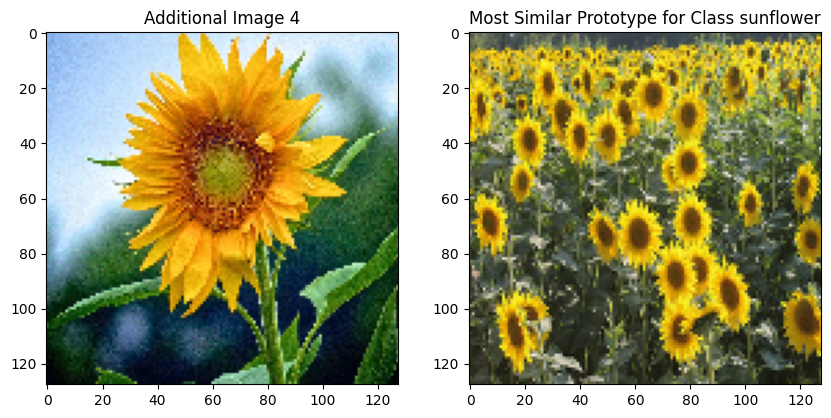

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


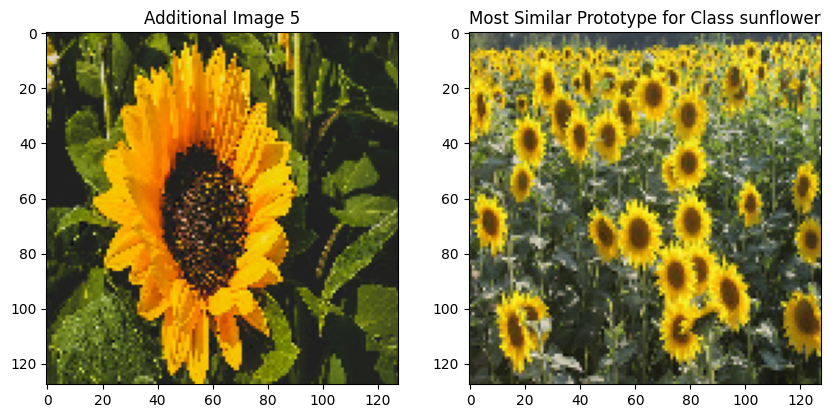

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


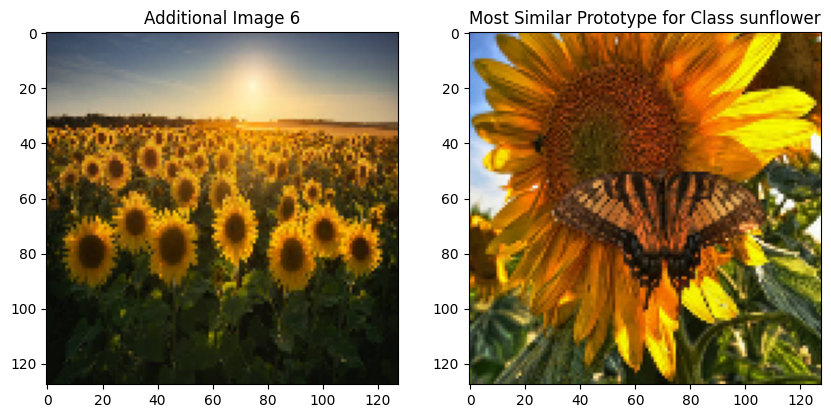

In [76]:
def match_prototypes(extra_embed, prototypes):
    min_distance = float('inf')
    closest_prototype = None
    for class_prototypes in prototypes:
        for prototype_type in ['best', 'worst', 'okay']:
            if prototype_type == 'okay':
                for proto in class_prototypes[prototype_type]:
                    distance = np.linalg.norm(extra_embed - proto)
                    if distance < min_distance:
                        min_distance = distance
                        closest_prototype = proto
            else:
                distance = np.linalg.norm(extra_embed - class_prototypes[prototype_type])
                if distance < min_distance:
                    min_distance = distance
                    closest_prototype = class_prototypes[prototype_type]
    return closest_prototype


for i, image in enumerate(additional_images):
    most_similar_prototype = match_prototypes(additional_embeddings[i], prototypes)

   
    predicted_class = np.argmax(cnn_model.predict(image[np.newaxis, ...]))
    class_name = ['rose', 'sunflower', 'uknown'][predicted_class]

    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Additional Image {i+1}")
    plt.subplot(1, 2, 2)
    plt.imshow(X_test[np.argmin(np.linalg.norm(X_test_embed - most_similar_prototype, axis=1))])
    plt.title(f"Most Similar Prototype for Class {class_name}")
    plt.show()

